In [4]:
import matplotlib.pyplot as plt
import calibration
import matplotlib.image as mpimg
import imagefilter
import glob
import warp
import findlane
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from line import Line
import drawlane
import cv2
%matplotlib inline

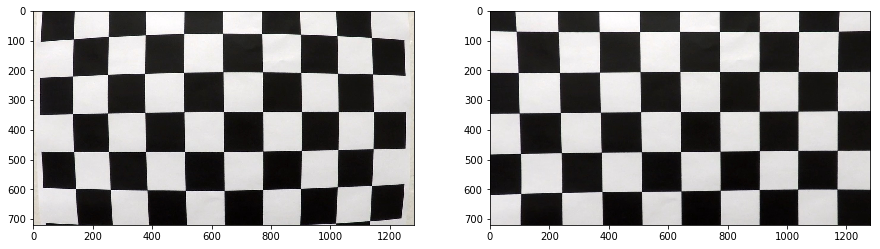

In [2]:
cal_image1 = mpimg.imread('camera_cal/calibration1.jpg')
output_image1 = mpimg.imread('output_images/undist_1.jpg')

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,9))
ax1.imshow(cal_image1)
ax2.imshow(output_image1)


In [5]:
def draw(img, mtx, origin):
    leftfit, rightfit, leftx, rightx, lefty, righty = findlane.find_lane(img)
    ploty = findlane.get_ploty()
    return drawlane.lane_image(img, origin,mtx, ploty, leftfit,rightfit)

In [6]:
def process(img, cali_dict=None, warp_m=None, in_m=None):
    if cali_dict is None:
        cali_dict = calibration.cam_cali()
    cali_img = calibration.cali_img(img, cali_dict)
    if warp_m is None:
        warp_src, warp_dst = warp.warp_points()
        warp_m, in_m = warp.warp_ms(warp_src,warp_dst)
    warped_img = warp.warp_img(cali_img, warp_m)
    filtered_img = imagefilter.color_gradient_filter(warped_img)
    return filtered_img

In [7]:
images =[mpimg.imread(img) for img in glob.glob("test_images/test*.jpg")]

In [8]:
cali_dict = calibration.cam_cali()
cali_images = [calibration.cali_img(img, cali_dict) for img in images]

In [9]:
def plot_twin(images1, images2):
    for i in range(0, len(images1)):
        plt.figure()
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,9))
        ax1.imshow(images1[i])
        ax2.imshow(images2[i])

# plot_twin(images, cali_images)

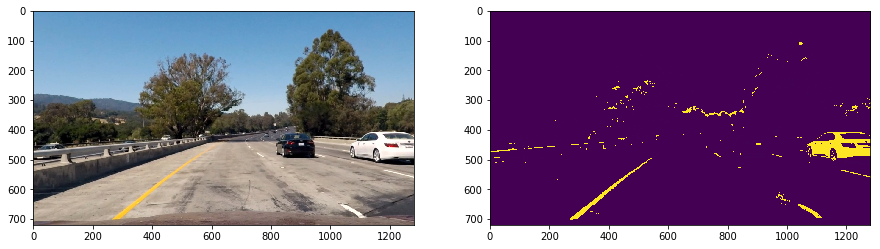

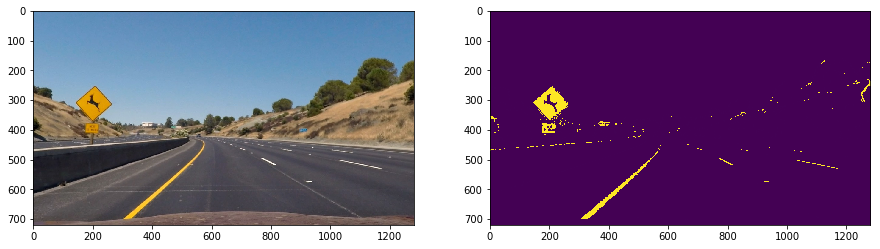

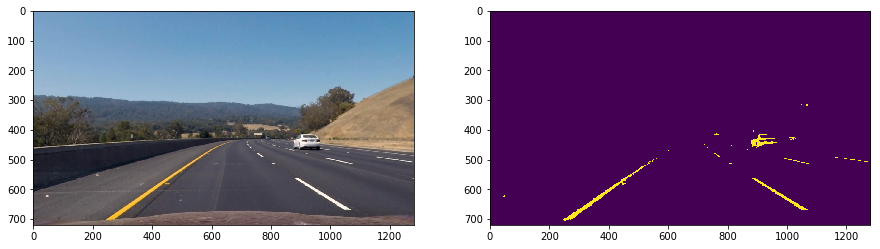

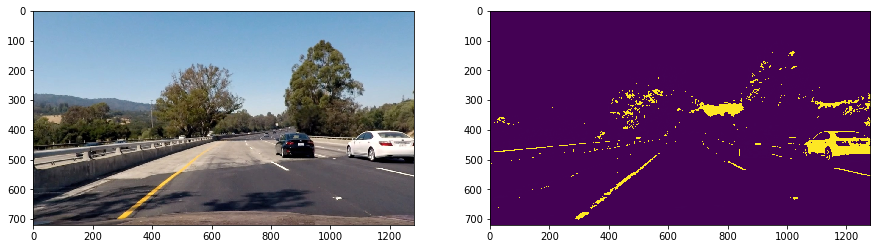

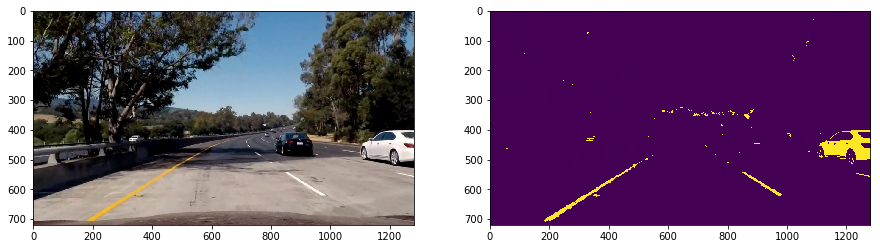

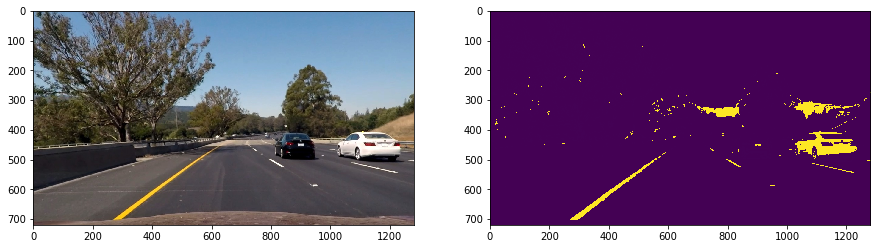

In [10]:
filtered_images = [imagefilter.color_gradient_filter(img) for img in cali_images]
plot_twin(cali_images, filtered_images)

In [11]:
src,dst = warp.warp_points()
m,in_m = warp.warp_ms(src, dst)

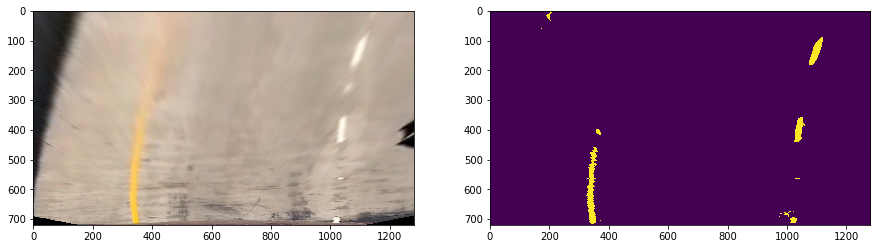

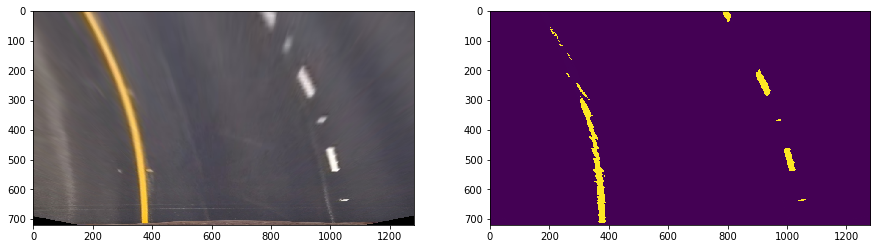

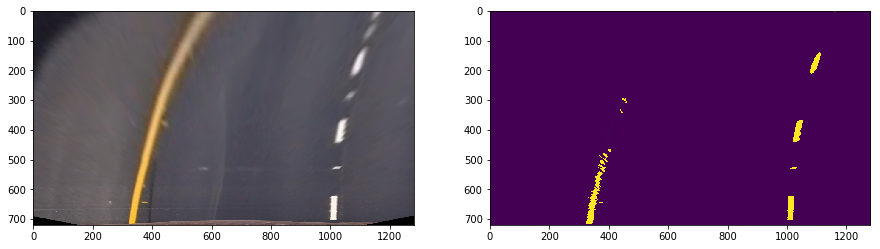

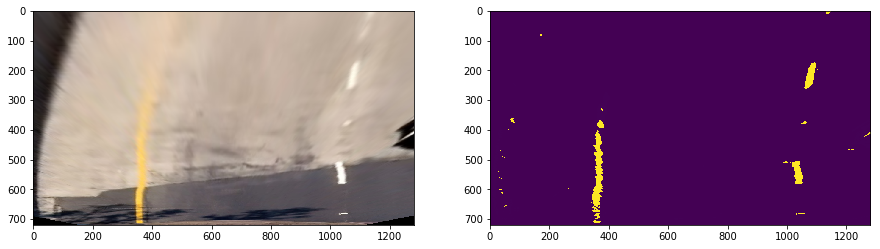

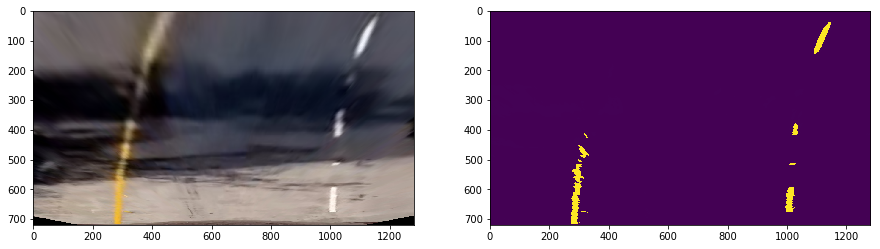

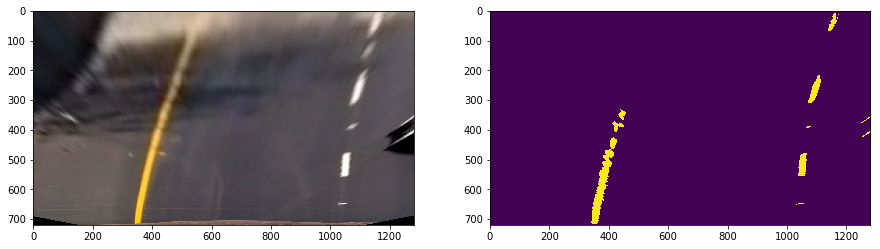

In [14]:
warped_images = [warp.warp_img(img,m) for img in cali_images]
filtered_warped_images = [imagefilter.color_gradient_filter(img) for img in warped_images]
plot_twin(warped_images, filtered_warped_images)

In [22]:
final_images = [draw(filtered_warped_images[i],in_m, images[i]) for i in range(0, len(images))]
plot_twin(filtered_warped_images, final_images)

TypeError: lane_image() missing 3 required positional arguments: 'left_curve', 'right_curve', and 'distance'

(720, 0)

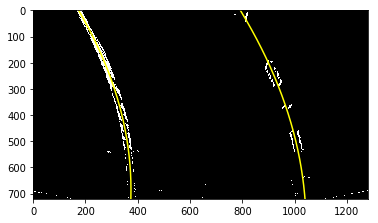

In [21]:
import numpy as np
bw = filtered_warped_images[1]
left_fit, right_fit, left_fitx, right_fitx, lefty, righty = findlane.find_lane(filtered_warped_images[1])
out_img = np.dstack((bw, bw, bw))*255
nonzero = bw.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])

ploty = np.linspace(0, bw.shape[0]-1, bw.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

# out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
# out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

In [23]:
processed_images = [process(img) for img in images]
#plot_twin(images, processed_images)

In [25]:
line1 = Line()
line1.update(processed_images[0])

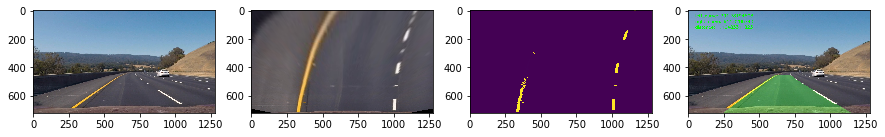

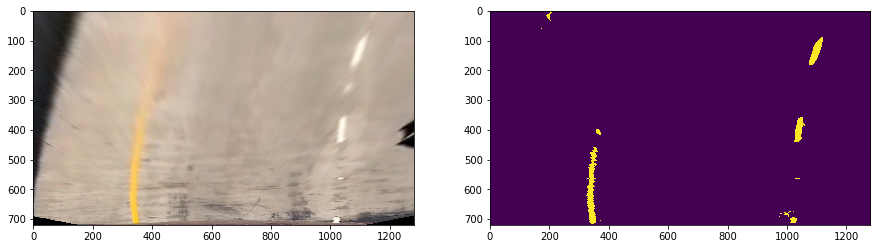

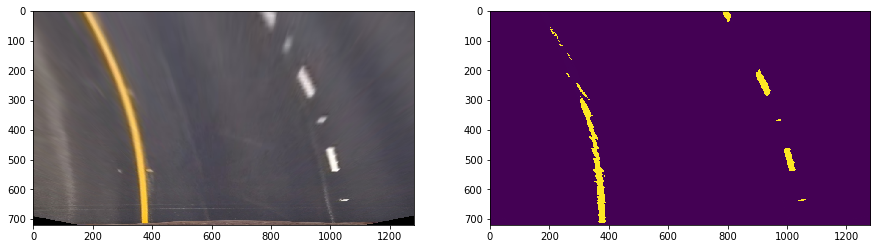

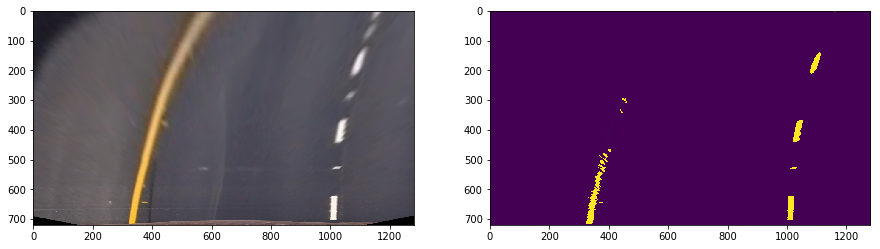

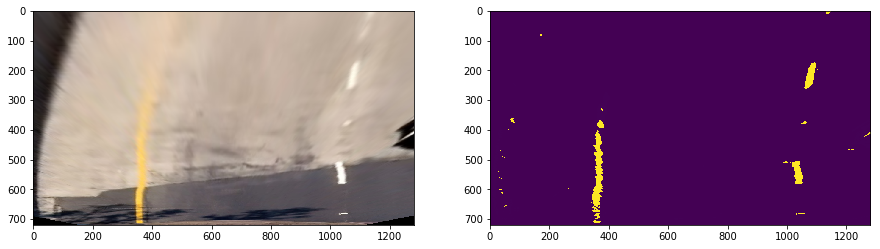

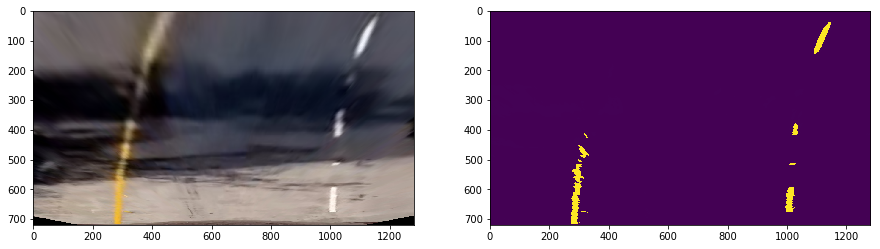

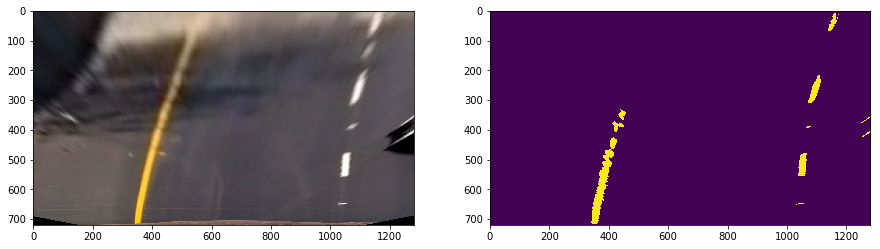

In [30]:
out_image = drawlane.lane_image(processed_images[2], images[2],in_m, line1.ploty, line1.left_best_fit,line1.right_best_fit,
                               line1.left_curve_m, line1.right_curve_m,
                                     line1.center_dist)
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(15,9))
plot_twin(warped_images, filtered_warped_images)
ax1.imshow(images[2])
ax2.imshow(warped_images[2])
ax3.imshow(filtered_warped_images[2])
ax4.imshow(out_image)

In [2]:
def process_video(video_file):
    lane_line = Line()
    cali_dict = calibration.cam_cali()
    warp_src, warp_dst = warp.warp_points()
    warp_m, in_m = warp.warp_ms(warp_src,warp_dst)

    def process_full(img):
        cali_img = calibration.cali_img(img, cali_dict)
        warped_img = warp.warp_img(cali_img, warp_m)
        filtered_img = imagefilter.color_gradient_filter(warped_img)
        lane_line.update(filtered_img)
        output = drawlane.lane_image(filtered_img, img,in_m, lane_line.ploty, lane_line.left_best_fit,lane_line.right_best_fit)
        return output
    clip = VideoFileClip(video_file)
    return clip.fl_image(process_full) #NOTE: this function expects color images!!

In [ ]:
white_output = 'output_1.mp4'
white_clip = process_video("project_video.mp4")
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video output_1.mp4
[MoviePy] Writing video output_1.mp4


 81%|████████  | 1018/1261 [01:58<00:32,  7.40it/s]

In [ ]:
white_output = 'output.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))